# First critic before starting
There is no way a classic sts worflow as defined in the simple doc and example provided works well as the data are count data, and are closer to a poisson process or a lognormal at least. 
So treating this process as a gaussian is wrong since the beginning and will lead to untractable results such as negative number of cancelation in posterior draw if we do not impose any restrictions on the model parameters

In [67]:
%matplotlib inline
import matplotlib as mpl
#from matplotlib import pylab as plot
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import collections

import pandas as pd
import numpy as np
#import tensorflow.compat.v2 as tf
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import bijectors as tfb

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

#tf.enable_v2_behavior()

In [153]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

# Import H1 data

In [132]:
raw_data = pd.read_csv('C:/Users/amaur/Documents/Data_science/Bayesian_TS/h1weekly.csv')
raw_data.head()

,Date,IsCanceled
0,2015-06-21,41
1,2015-06-28,48
2,2015-07-05,87
3,2015-07-12,74
4,2015-07-19,101


In [133]:
raw_data['Date'] = pd.to_datetime(raw_data['Date'])

# Calculate min and max date
min_date = raw_data['Date'].min()
max_date = raw_data['Date'].max()

# Generate weekly interval using pandas date_range
weekly_dates = pd.date_range(start=min_date, end=max_date, freq='W')

# Convert the pandas DatetimeIndex to a numpy.ndarray with datetime64 type
cancelation_dates = weekly_dates.to_numpy(dtype=np.datetime64)
cancelation_dates = cancelation_dates.astype('datetime64[W]')

## date printing formater 
cancelation_loc = mdates.DayLocator(interval=31)
cancelation_fmt = mdates.DateFormatter('%Y-%m')

## Number of forcasting steps (half a year)
num_forecast_steps = 8

## Formating time serie data
serial_data = raw_data.IsCanceled.tolist()
serial_data = np.array(serial_data).astype(np.float32)
## Training_data
training_data = serial_data[:-num_forecast_steps]


# Plotting data

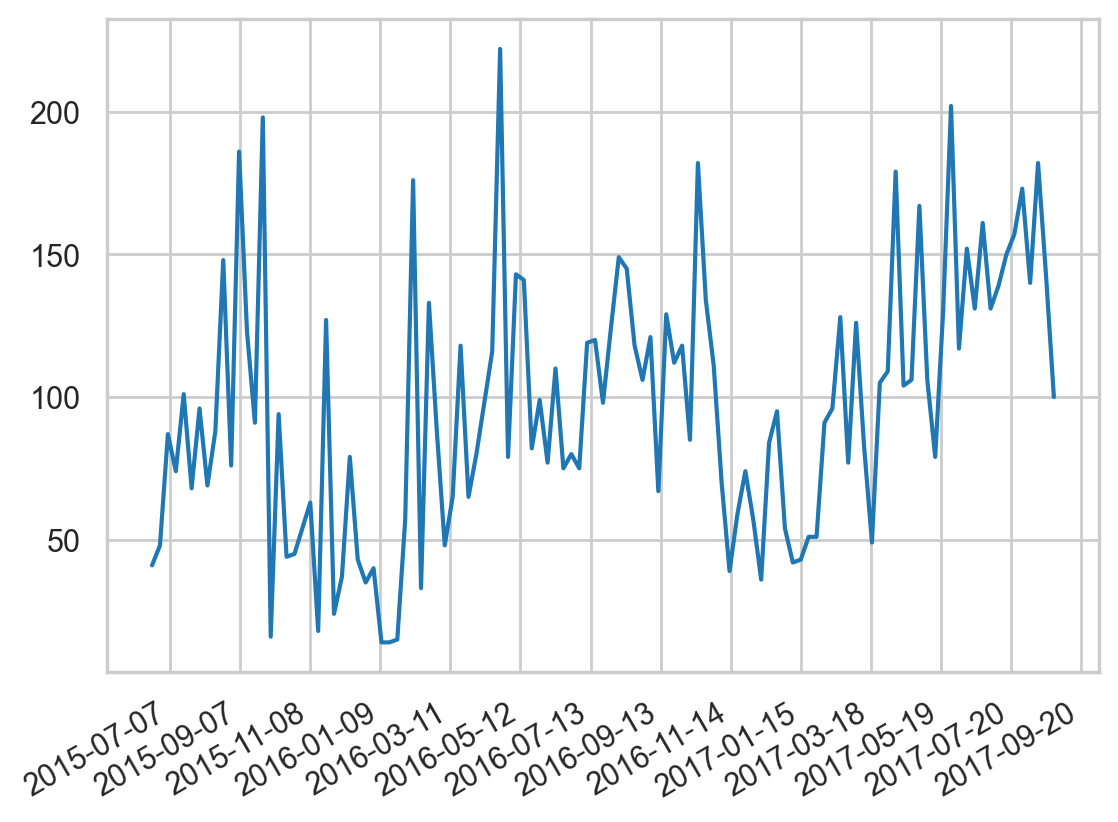

In [134]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=62))
plt.plot(raw_data.Date, raw_data.IsCanceled)
plt.gcf().autofmt_xdate()
plt.show()

Ok so from a basic plotting and at first sight :
Note that I would not like to analyse such a dataset IRL as the component of the structural time serie we may want to model and that we observe can be due to the cyclicity in reservation rather than in cancelation (i.e. a drop in raw cancelation observed might come from the fact that there is less reservation rather than an intrinsic process pushing people to cancel more). Anyway point is forecast not inference
- the process seems stationnary although a small trend is not to exclude
- It is not clear how seasonnality is defined, or is there many (bi-annually, monthly weekly)

---

## Time serie decomposition : Be more robust than simple visual analysis
- Objective : have a first idea on which type of component we will include in the STS framework (is there a trend that we did not see ? Is there a seasonnality and to which frequency)
- Method_1 : We could check if the data are stationnary - exclude trend if data are and check at an ACF to see pick of correlation for seasonnality (say we are interested at infra year seasonnality as theory in hostel business pushes us toward thinking of quarterly cancelation scheme a bit before summer and a bit before christmas - if data come from northern hemisphere christian countries). Method 1 is scientifically robust but less visual and easy to interpret
- Method_2 : Use the deasonal decomposition function from statsmodel which makes it easy to visualy interpret

Let us use method_2


<Figure size 1000x800 with 0 Axes>

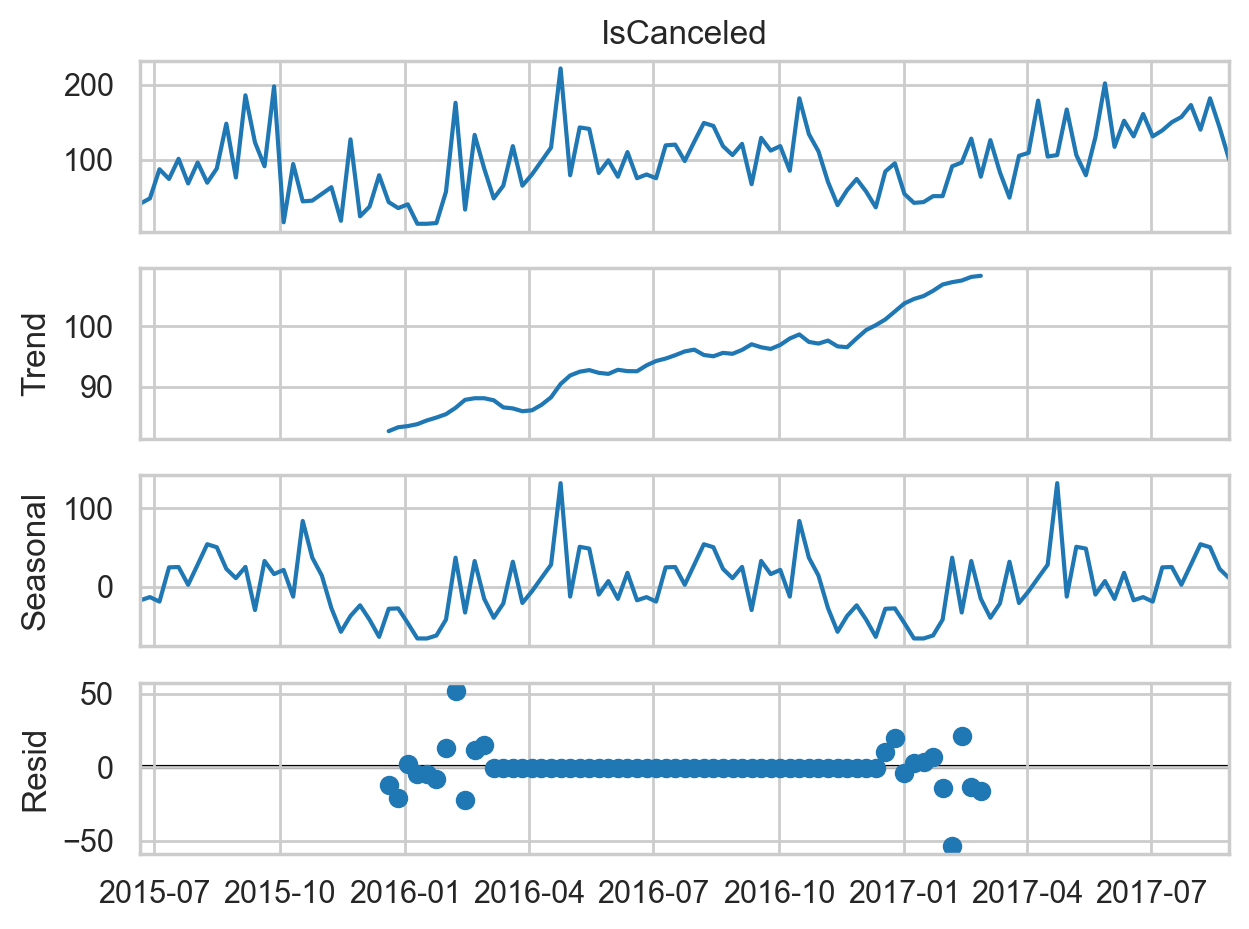

In [135]:
indexed_raw_data = raw_data.set_index('Date')
indexed_raw_data.index.freq = 'W'
decomposition = seasonal_decompose(indexed_raw_data['IsCanceled'], model='additive')
plt.figure(figsize=(10, 8))
decomposition.plot()
plt.show()

What we conclude for component to include in our structural time serie modelling
- We should include a local trend
- We should include a seasonnality (indeed quarterly)
    - we see picks in november, and may (in a more moderate proportion in july)
    - we see slumps between november and january
    - As our frequency is defined weekly, we have a seasonnality every 26 weeks

## Now let us check if there is a specific structure of ARMA type in order to monitor variance that could be explosive in such a model

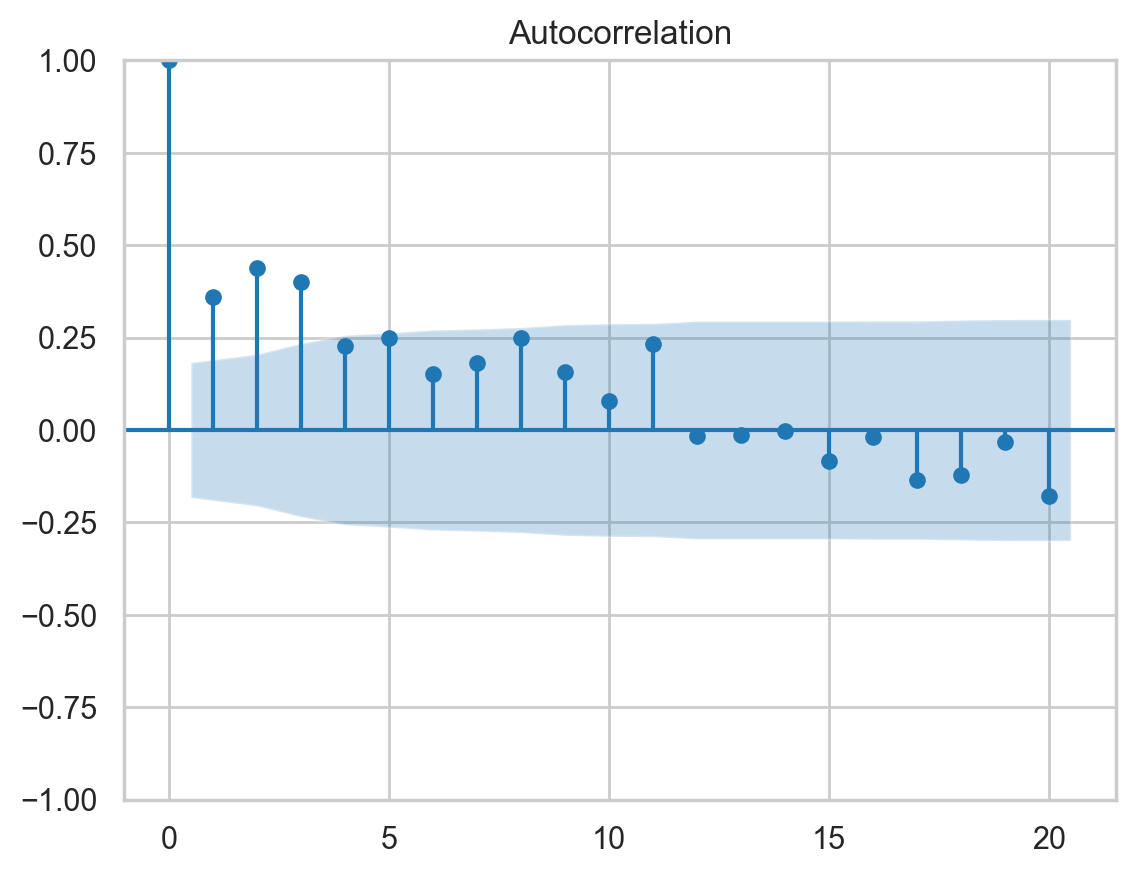

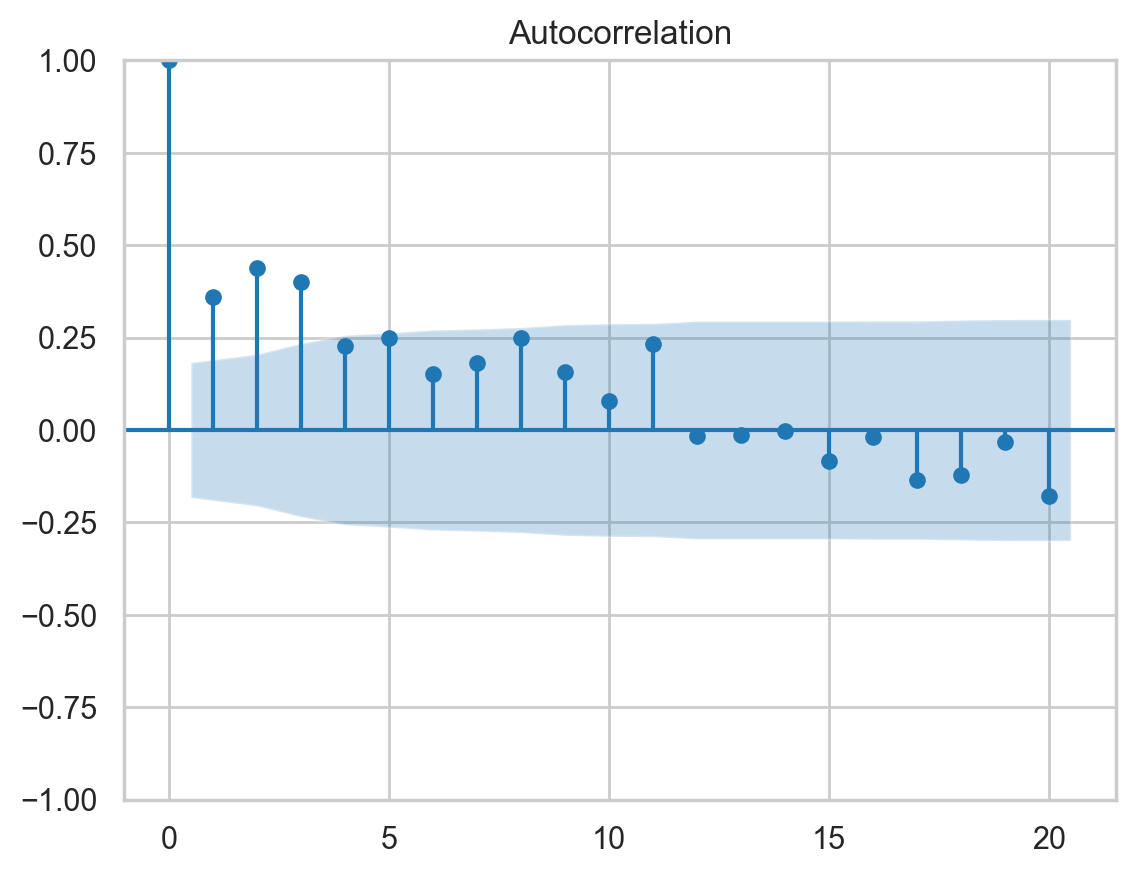

In [136]:
acf,confidence_interval=sm.tsa.acf(serial_data, nlags=20 ,alpha=0.05, fft=False)
plot_acf(serial_data, lags=20)

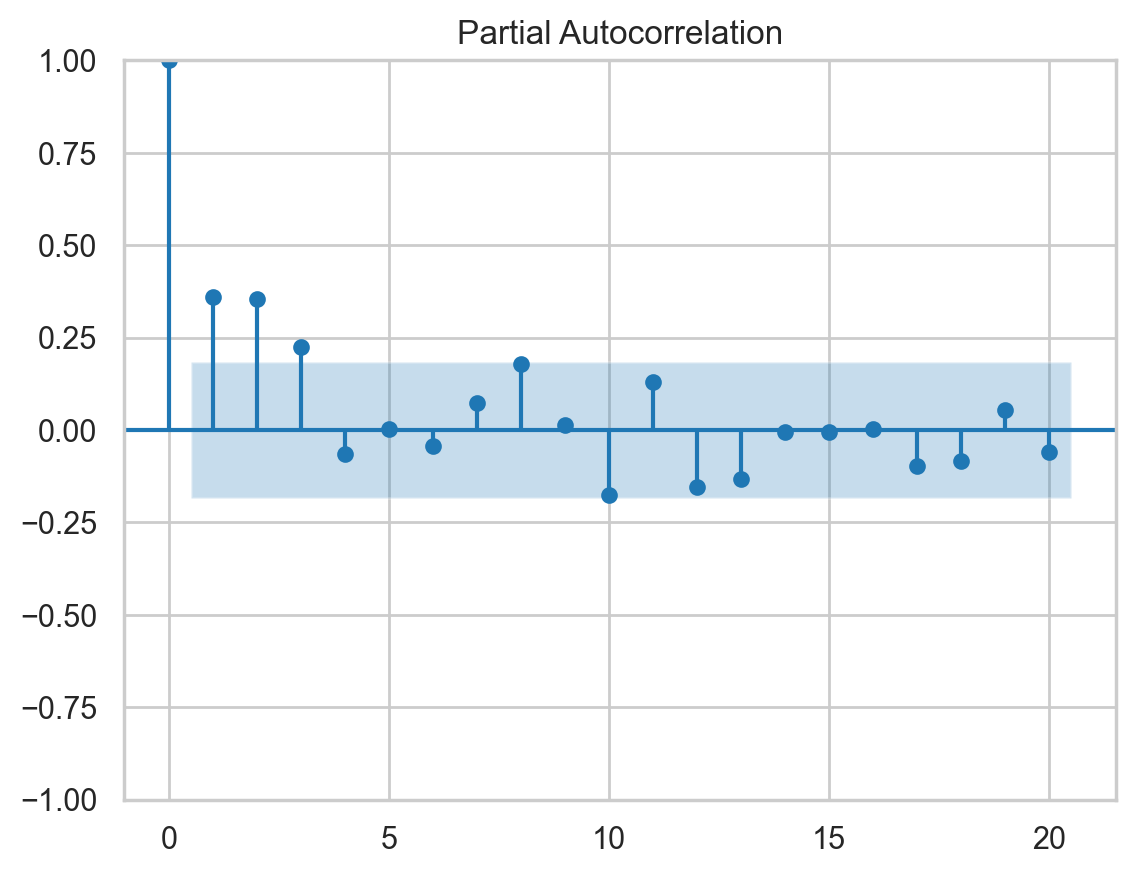

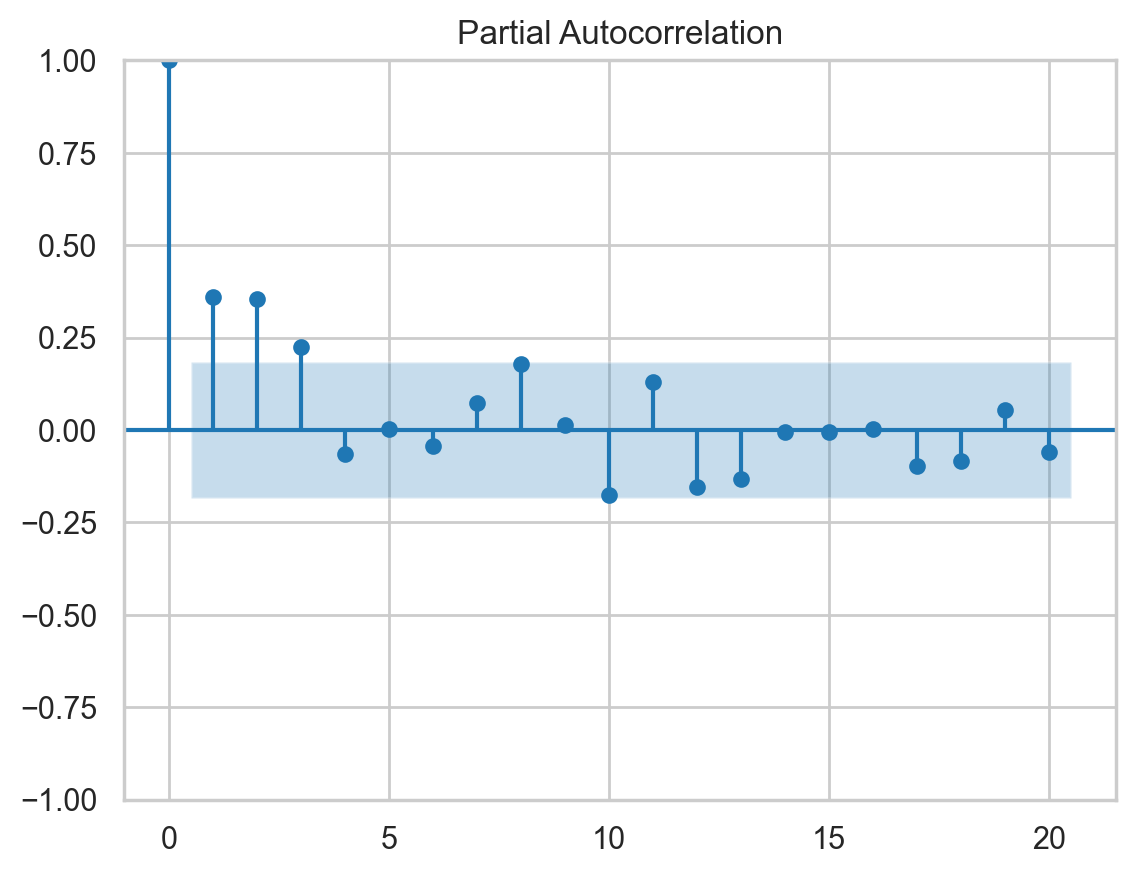

In [137]:
pacf,confidence_interval=sm.tsa.pacf(serial_data, nlags=20 ,alpha=0.05)
plot_pacf(serial_data, lags=20)

Given the ACF and PACF plots we can reasonnably bet on a ARMA(3,3) process that we want to integrate in the STS we create

---

# Structural Time Serie Modelling : Create model and optimize

In [138]:
def build_model(observed_time_series, ar, ma):
  trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
  seasonal_semester = tfp.sts.Seasonal(num_seasons=4, num_steps_per_season = 13, observed_time_series=observed_time_series,
  name = 'semester variation')
  monthly_effect = tfp.sts.Seasonal(num_seasons=52, observed_time_series=observed_time_series,
  name = 'infra month variation')
  arma = tfp.sts.AutoregressiveIntegratedMovingAverage(ar_order=ar, ma_order=ma, observed_time_series=observed_time_series)
  model = sts.Sum([trend, monthly_effect, seasonal_semester, arma], observed_time_series=observed_time_series)
  return model

In [139]:
cancelation_model = build_model(training_data, 4, 4)
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=cancelation_model)

In [140]:
# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 400 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

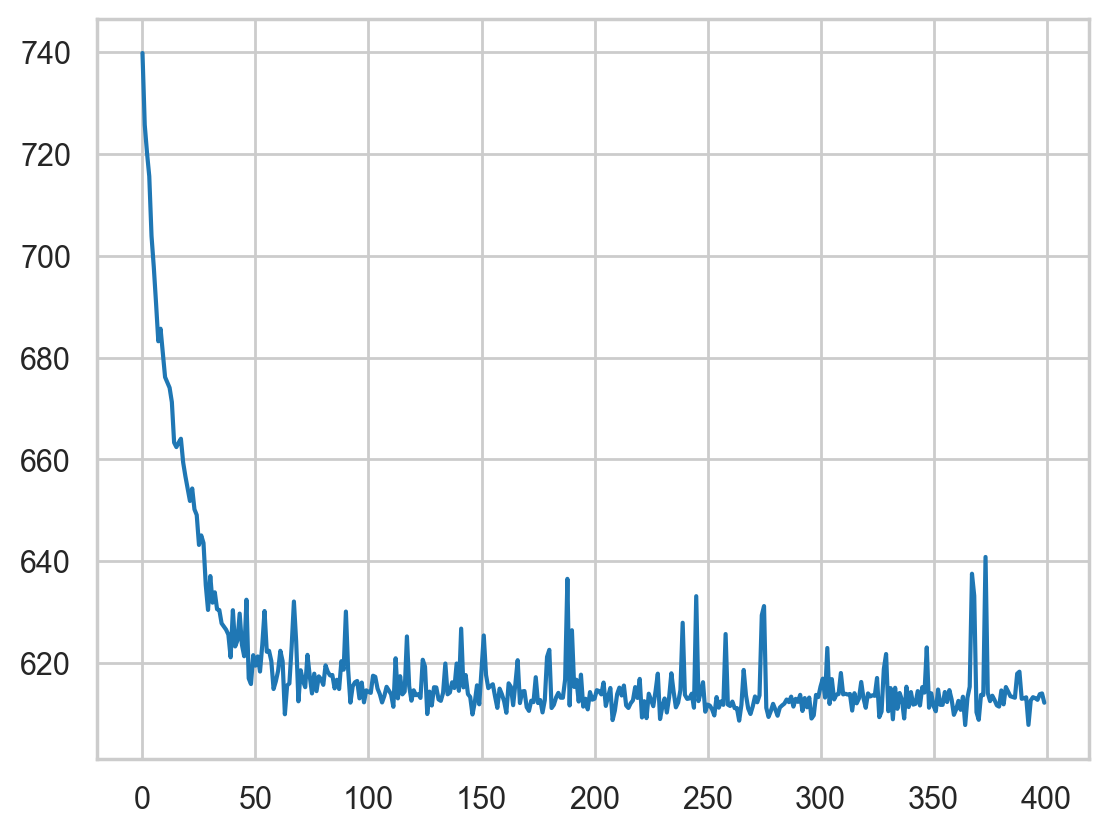

In [141]:
# Build and optimize the variational loss function.
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=cancelation_model.joint_distribution(observed_time_series=training_data).log_prob,
    surrogate_posterior=variational_posteriors,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=num_variational_steps,
    jit_compile=True)

plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples_cancelation_ = variational_posteriors.sample(100)

---
# Doing forecasting

In [154]:
cancelation_forecast_dist = tfp.sts.forecast(
    cancelation_model,
    observed_time_series=training_data,
    parameter_samples=q_samples_cancelation_,
    num_steps_forecast=num_forecast_steps)

# Number of scenarii (draws from posterior distribution)
num_samples=10

cancelation_forecast_mean, cancelation_forecast_scale, cancelation_forecast_samples = (
    cancelation_forecast_dist.mean().numpy()[..., 0],
    cancelation_forecast_dist.stddev().numpy()[..., 0],
    cancelation_forecast_dist.sample(num_samples).numpy()[..., 0])

--
### plotting

In [143]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast


  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

In [144]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(12, 2.5 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

ValueError: Axis limits cannot be NaN or Inf

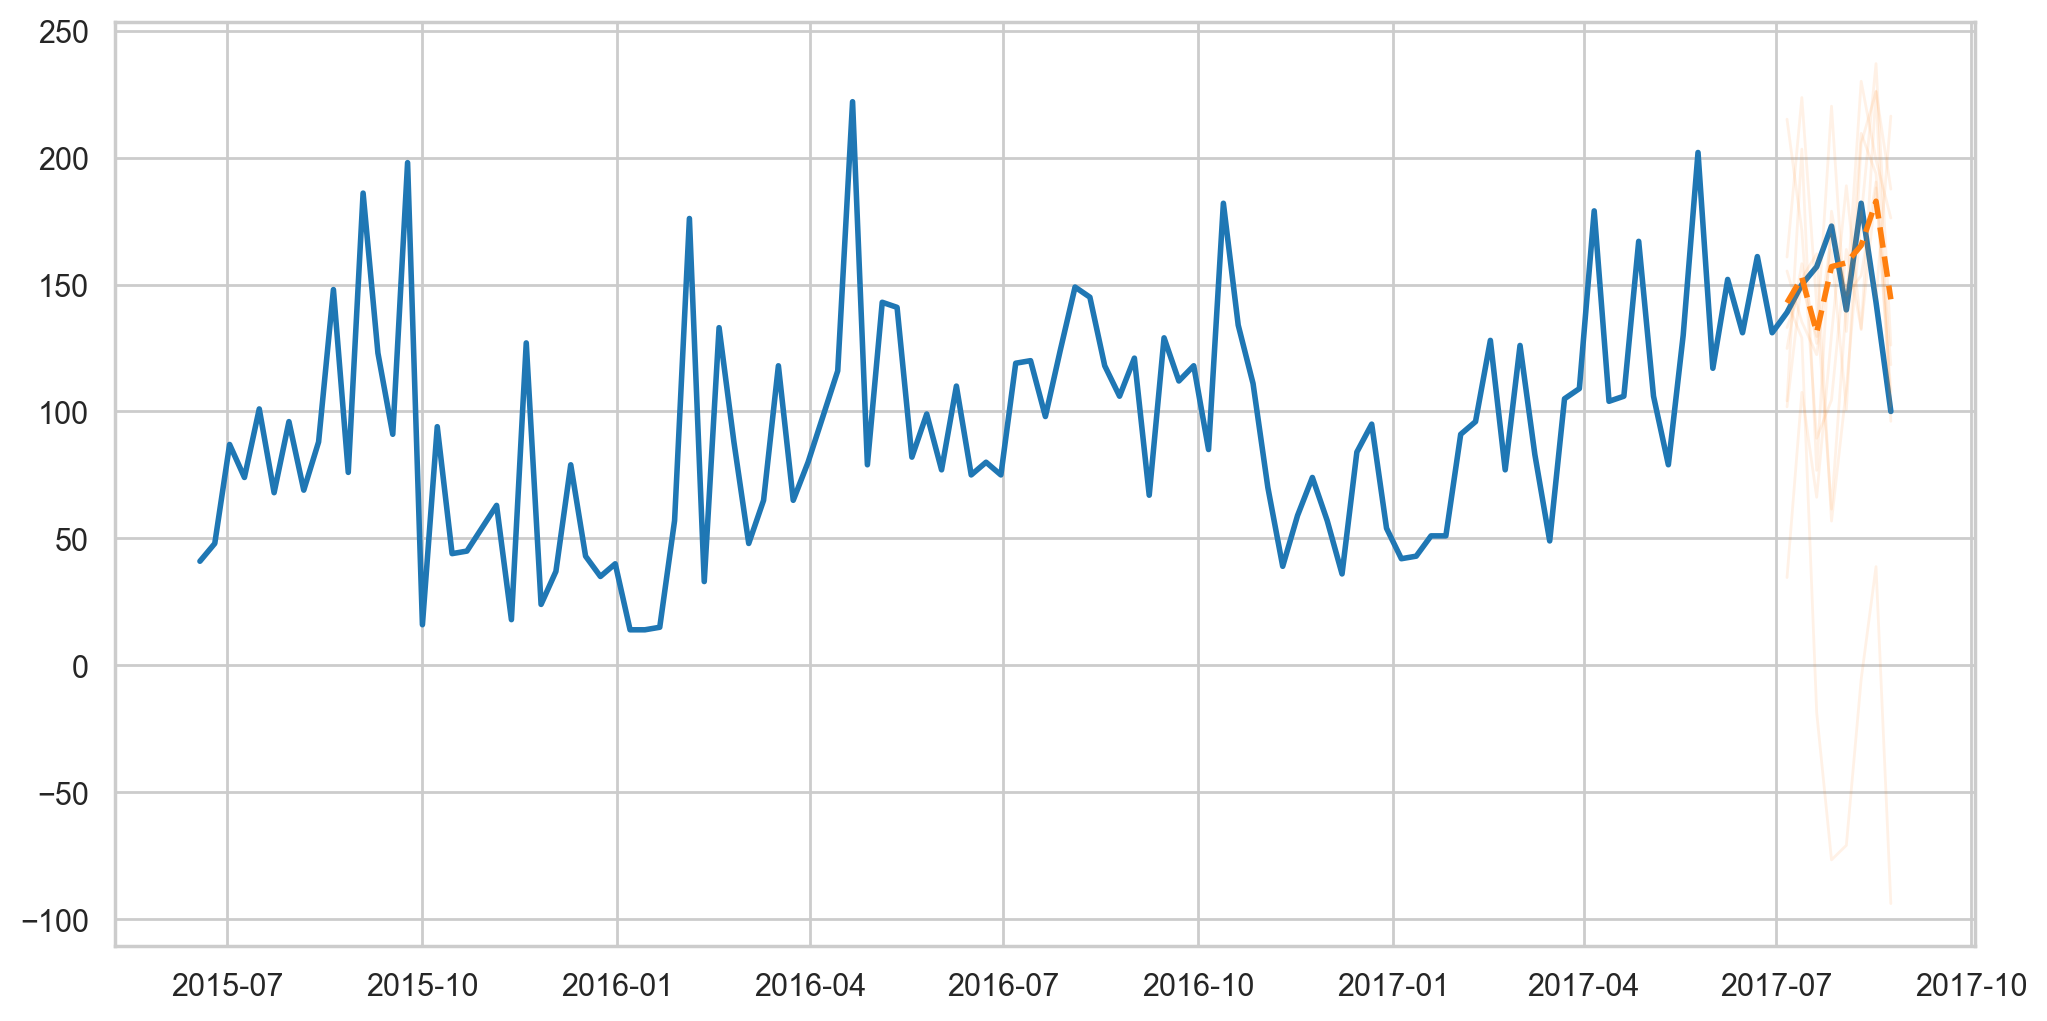

In [155]:
fig, ax = plot_forecast(
    cancelation_dates, serial_data,
    cancelation_forecast_mean, cancelation_forecast_scale, cancelation_forecast_samples,
    x_locator=cancelation_loc,
    x_formatter=cancelation_fmt,
    title="cancelation forecast")
ax.axvline(cancelation_dates[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("number cancelation")
ax.set_xlabel("Dates")
fig.autofmt_xdate()

In [156]:
### Mapping model components
component_dists = sts.decompose_by_component(
    cancelation_model,
    observed_time_series=training_data,
    parameter_samples=q_samples_cancelation_)

forecast_component_dists = sts.decompose_forecast_by_component(
    cancelation_model,
    forecast_dist=cancelation_forecast_dist,
    parameter_samples=q_samples_cancelation_)

In [157]:
cancelation_component_means_, cancelation_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

(
    cancelation_forecast_component_means_,
    cancelation_forecast_component_stddevs_
) = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
    )

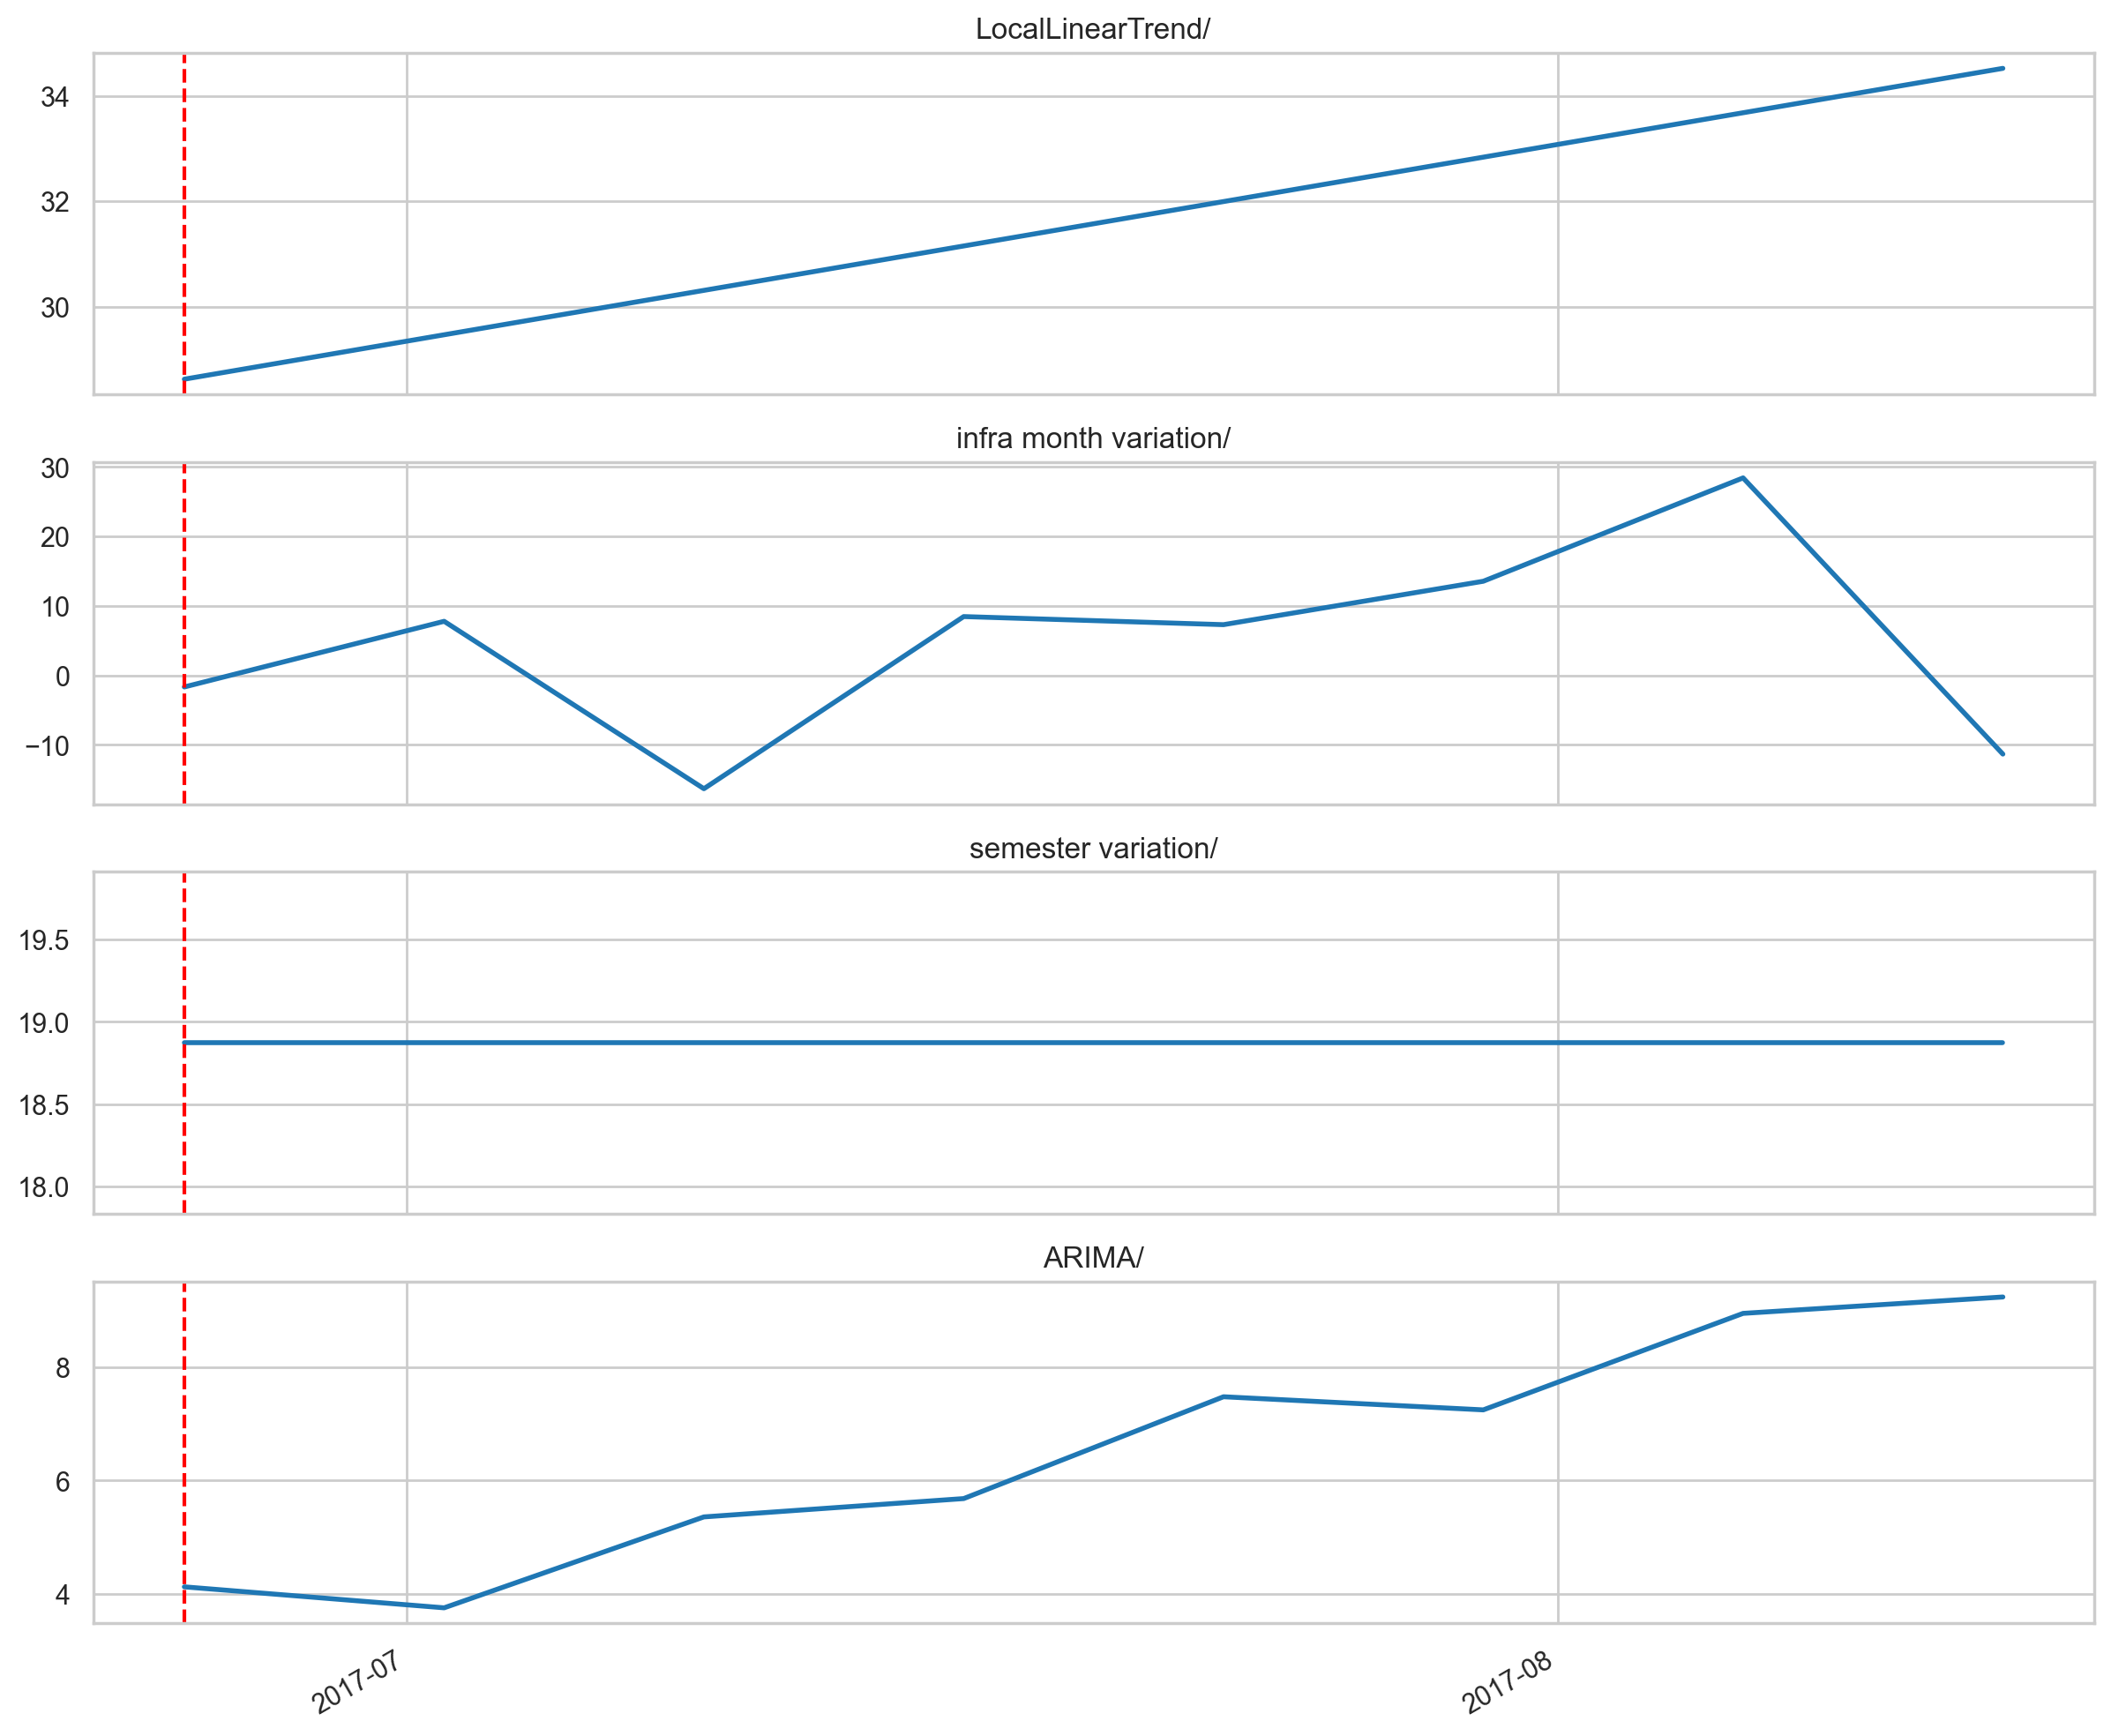

In [158]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in cancelation_component_means_.keys():
  component_with_forecast_means_[k] = np.concatenate([
      cancelation_component_means_[k],
      cancelation_forecast_component_means_[k]], axis=-1)
  component_with_forecast_stddevs_[k] = np.concatenate([
      cancelation_component_stddevs_[k],
      cancelation_forecast_component_stddevs_[k]], axis=-1)


fig, axes = plot_components(
  cancelation_dates,
  component_with_forecast_means_,
  component_with_forecast_stddevs_,
  x_locator=cancelation_loc, x_formatter=cancelation_fmt)
for ax in axes.values():
  ax.axvline(cancelation_dates[-num_forecast_steps], linestyle="--", color='red')

# One step prediction

In [159]:
cancelation_one_step_dist = sts.one_step_predictive(
    cancelation_model,
    observed_time_series=serial_data,
    parameter_samples=q_samples_cancelation_)

cancelation_one_step_mean, cancelation_one_step_scale = (
    cancelation_one_step_dist.mean().numpy(), cancelation_one_step_dist.stddev().numpy())

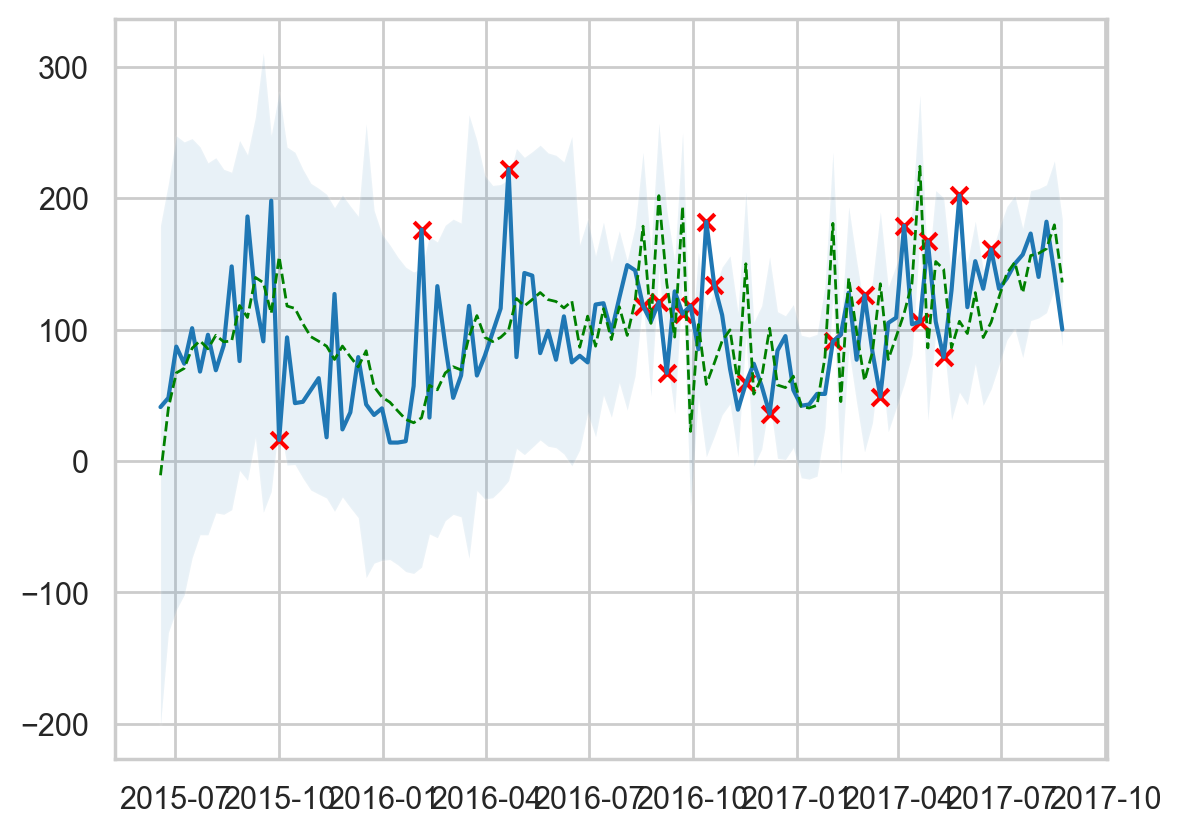

In [160]:
plt.plot(cancelation_dates, serial_data, label='Observed Time Series')

lower_bound = cancelation_one_step_mean - cancelation_one_step_scale
upper_bound = cancelation_one_step_mean + cancelation_one_step_scale

plt.fill_between(cancelation_dates, lower_bound, upper_bound, alpha=0.1, label='One Step Prediction Interval')

plt.plot(cancelation_dates, cancelation_one_step_mean, color='green', linestyle='--', linewidth=1, label='One Step Prediction')

outliers = (serial_data < lower_bound) | (serial_data > upper_bound)
outlier_indices = np.where(outliers)[0]
_ = plt.scatter(cancelation_dates[outlier_indices], serial_data[outliers], marker='x', color='red', label='Outliers')

---
# Repeating analysis on H2 dataset
        

In [106]:
raw_data = pd.read_csv('C:/Users/amaur/Documents/Data_science/Bayesian_TS/h2weekly.csv')
raw_data.head()

,Date,IsCanceled
0,2015-06-21,97
1,2015-06-28,153
2,2015-07-05,228
3,2015-07-12,321
4,2015-07-19,159


In [107]:
raw_data['Date'] = pd.to_datetime(raw_data['Date'])

# Calculate min and max date
min_date = raw_data['Date'].min()
max_date = raw_data['Date'].max()

# Generate weekly interval using pandas date_range
weekly_dates = pd.date_range(start=min_date, end=max_date, freq='W')

# Convert the pandas DatetimeIndex to a numpy.ndarray with datetime64 type
cancelation_dates = weekly_dates.to_numpy(dtype=np.datetime64)
cancelation_dates = cancelation_dates.astype('datetime64[W]')

## date printing formater 
cancelation_loc = mdates.DayLocator(interval=31)
cancelation_fmt = mdates.DateFormatter('%Y-%m')

## Number of forcasting steps (half a year)
num_forecast_steps = 8

## Formating time serie data
serial_data = raw_data.IsCanceled.tolist()
serial_data = np.array(serial_data).astype(np.float32)
## Training_data
training_data = serial_data[:-num_forecast_steps]

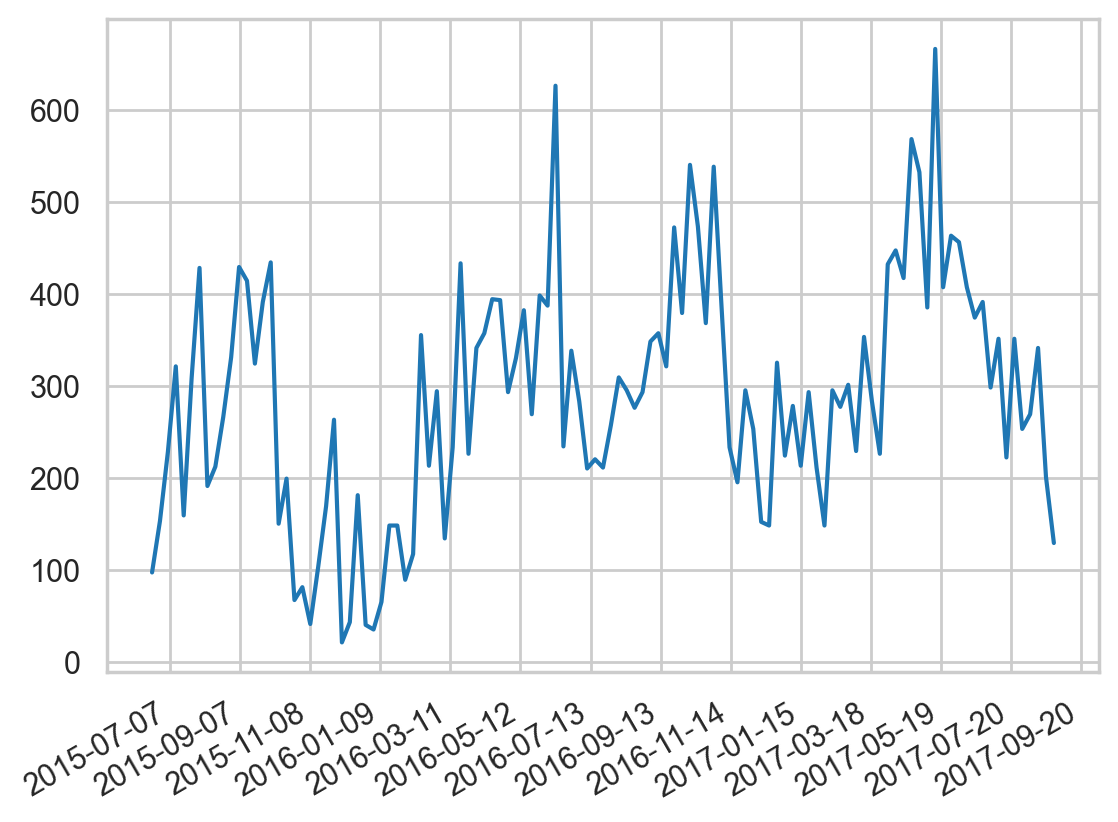

In [108]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=62))
plt.plot(raw_data.Date, raw_data.IsCanceled)
plt.gcf().autofmt_xdate()
plt.show()

<Figure size 1000x800 with 0 Axes>

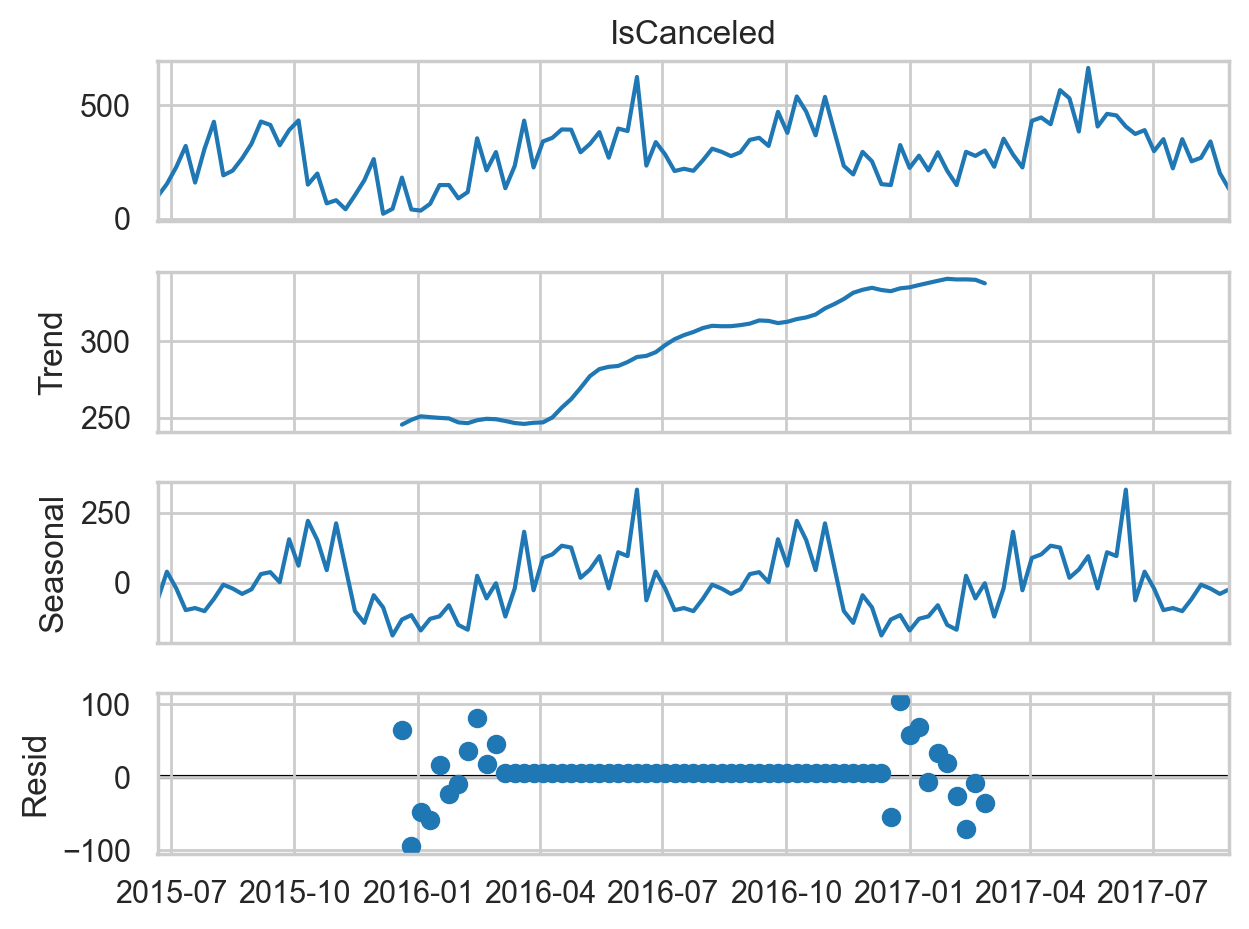

In [109]:
indexed_raw_data = raw_data.set_index('Date')
indexed_raw_data.index.freq = 'W'
decomposition = seasonal_decompose(indexed_raw_data['IsCanceled'], model='additive')
plt.figure(figsize=(10, 8))
decomposition.plot()
plt.show()

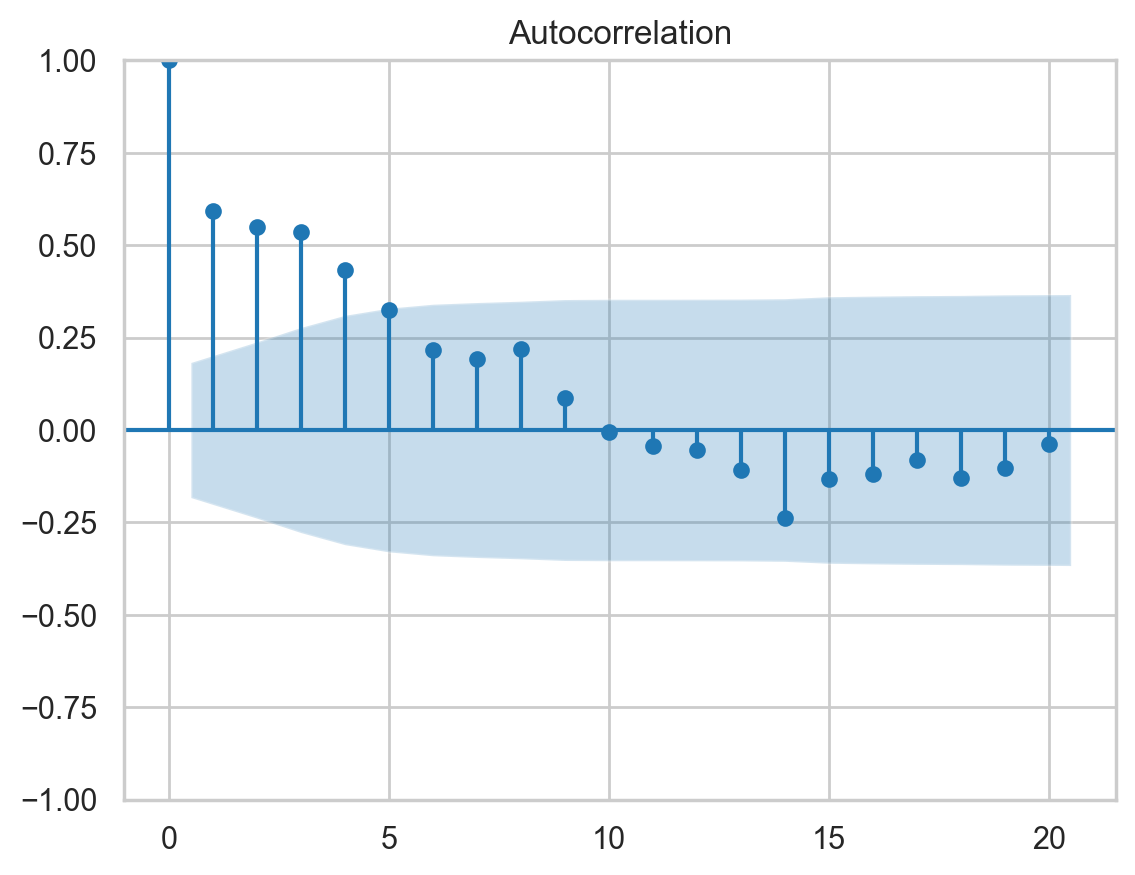

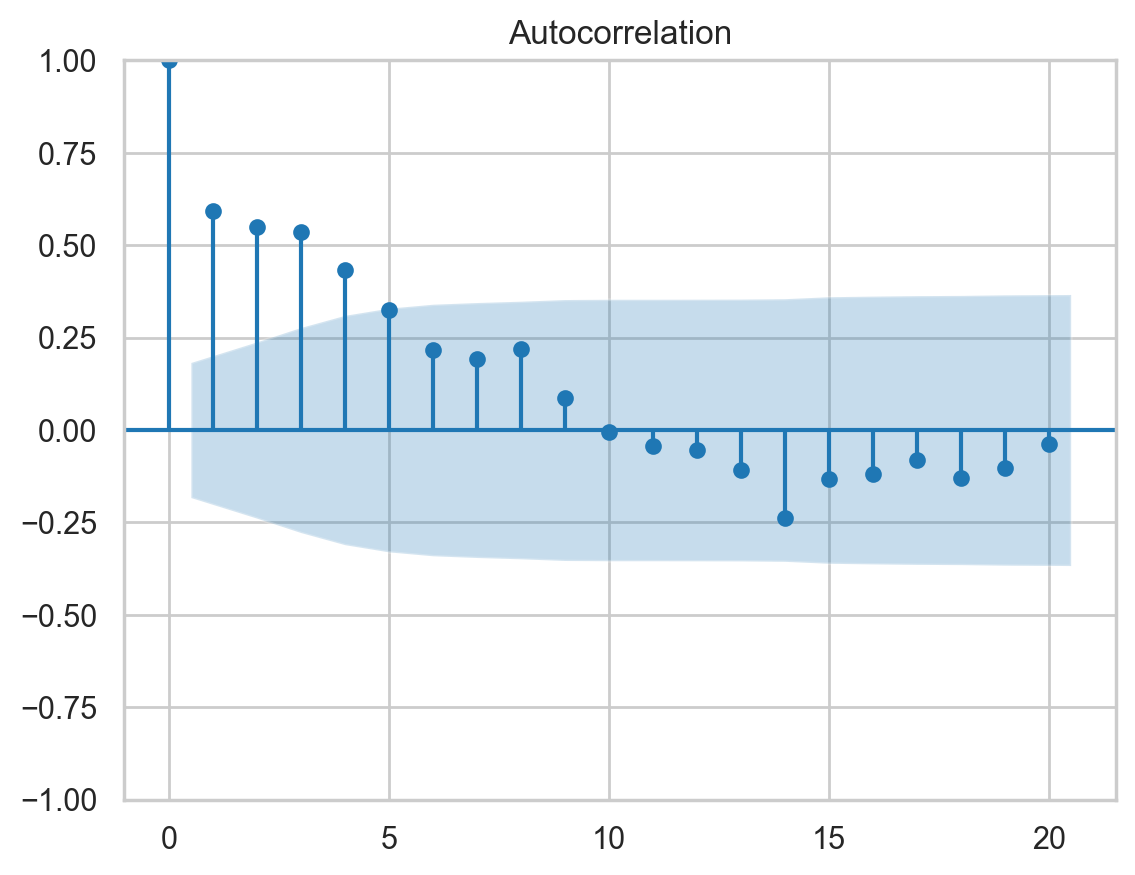

In [110]:
acf,confidence_interval=sm.tsa.acf(serial_data, nlags=20 ,alpha=0.05, fft=False)
plot_acf(serial_data, lags=20)

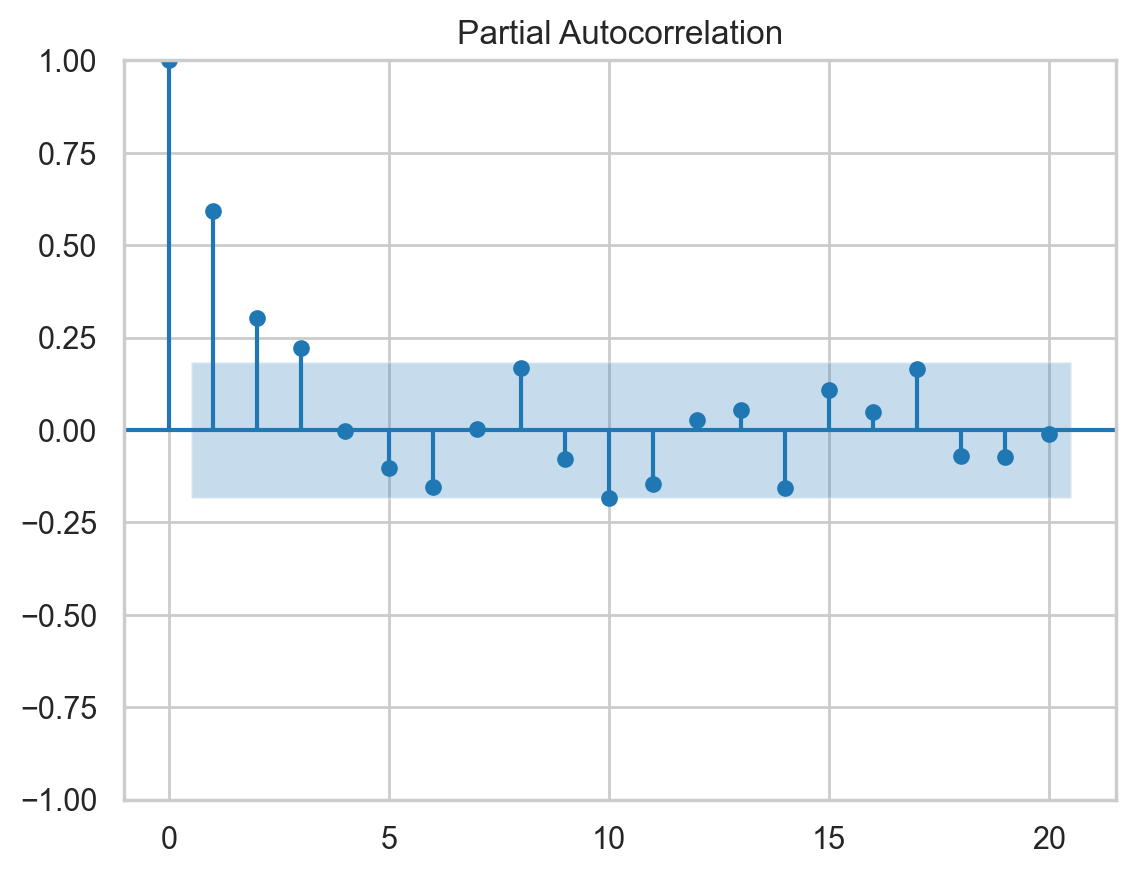

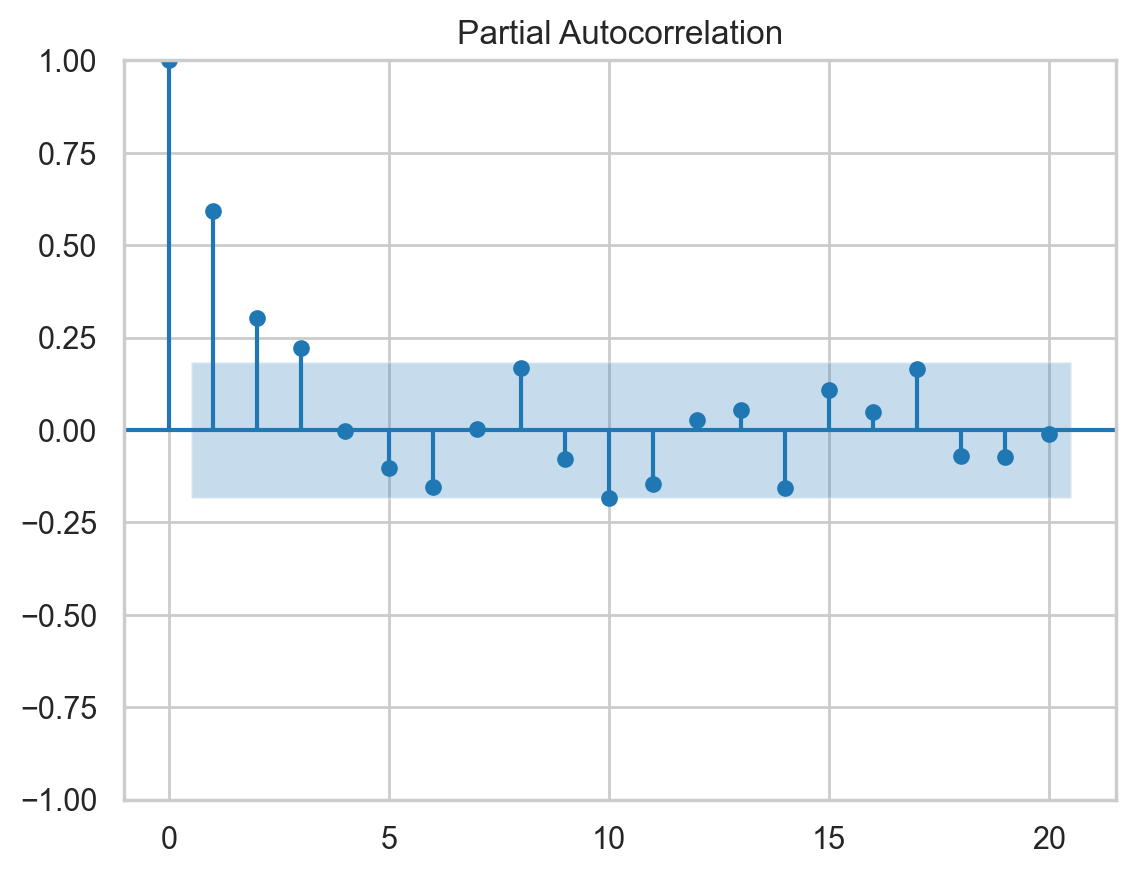

In [111]:
pacf,confidence_interval=sm.tsa.pacf(serial_data, nlags=20 ,alpha=0.05)
plot_pacf(serial_data, lags=20)

In [113]:
cancelation_model = build_model(training_data, 6, 4)
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=cancelation_model)

In [114]:
# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 400 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

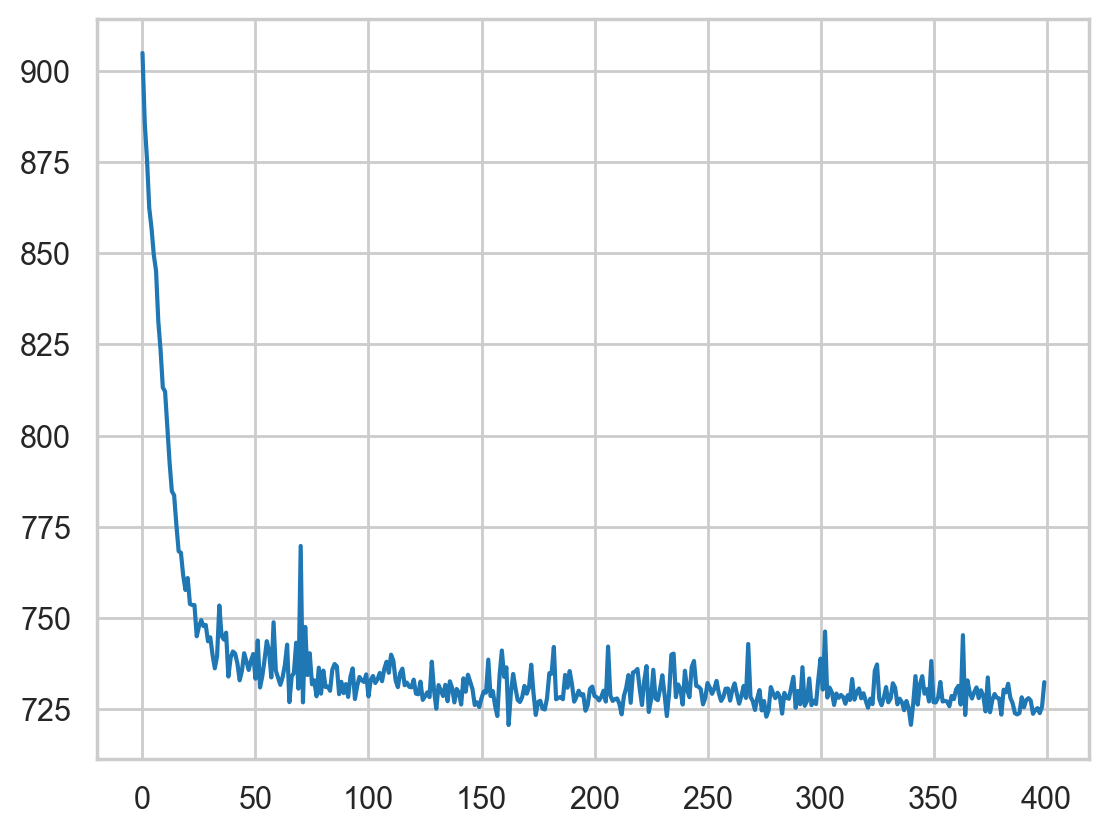

In [115]:
# Build and optimize the variational loss function.
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=cancelation_model.joint_distribution(observed_time_series=training_data).log_prob,
    surrogate_posterior=variational_posteriors,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=num_variational_steps,
    jit_compile=True)

plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples_cancelation_ = variational_posteriors.sample(100)

In [118]:
cancelation_forecast_dist = tfp.sts.forecast(
    cancelation_model,
    observed_time_series=training_data,
    parameter_samples=q_samples_cancelation_,
    num_steps_forecast=num_forecast_steps)

# Number of scenarii (draws from posterior distribution)
num_samples=10

cancelation_forecast_mean, cancelation_forecast_scale, cancelation_forecast_samples = (
    cancelation_forecast_dist.mean().numpy()[..., 0],
    cancelation_forecast_dist.stddev().numpy()[..., 0],
    cancelation_forecast_dist.sample(num_samples).numpy()[..., 0])

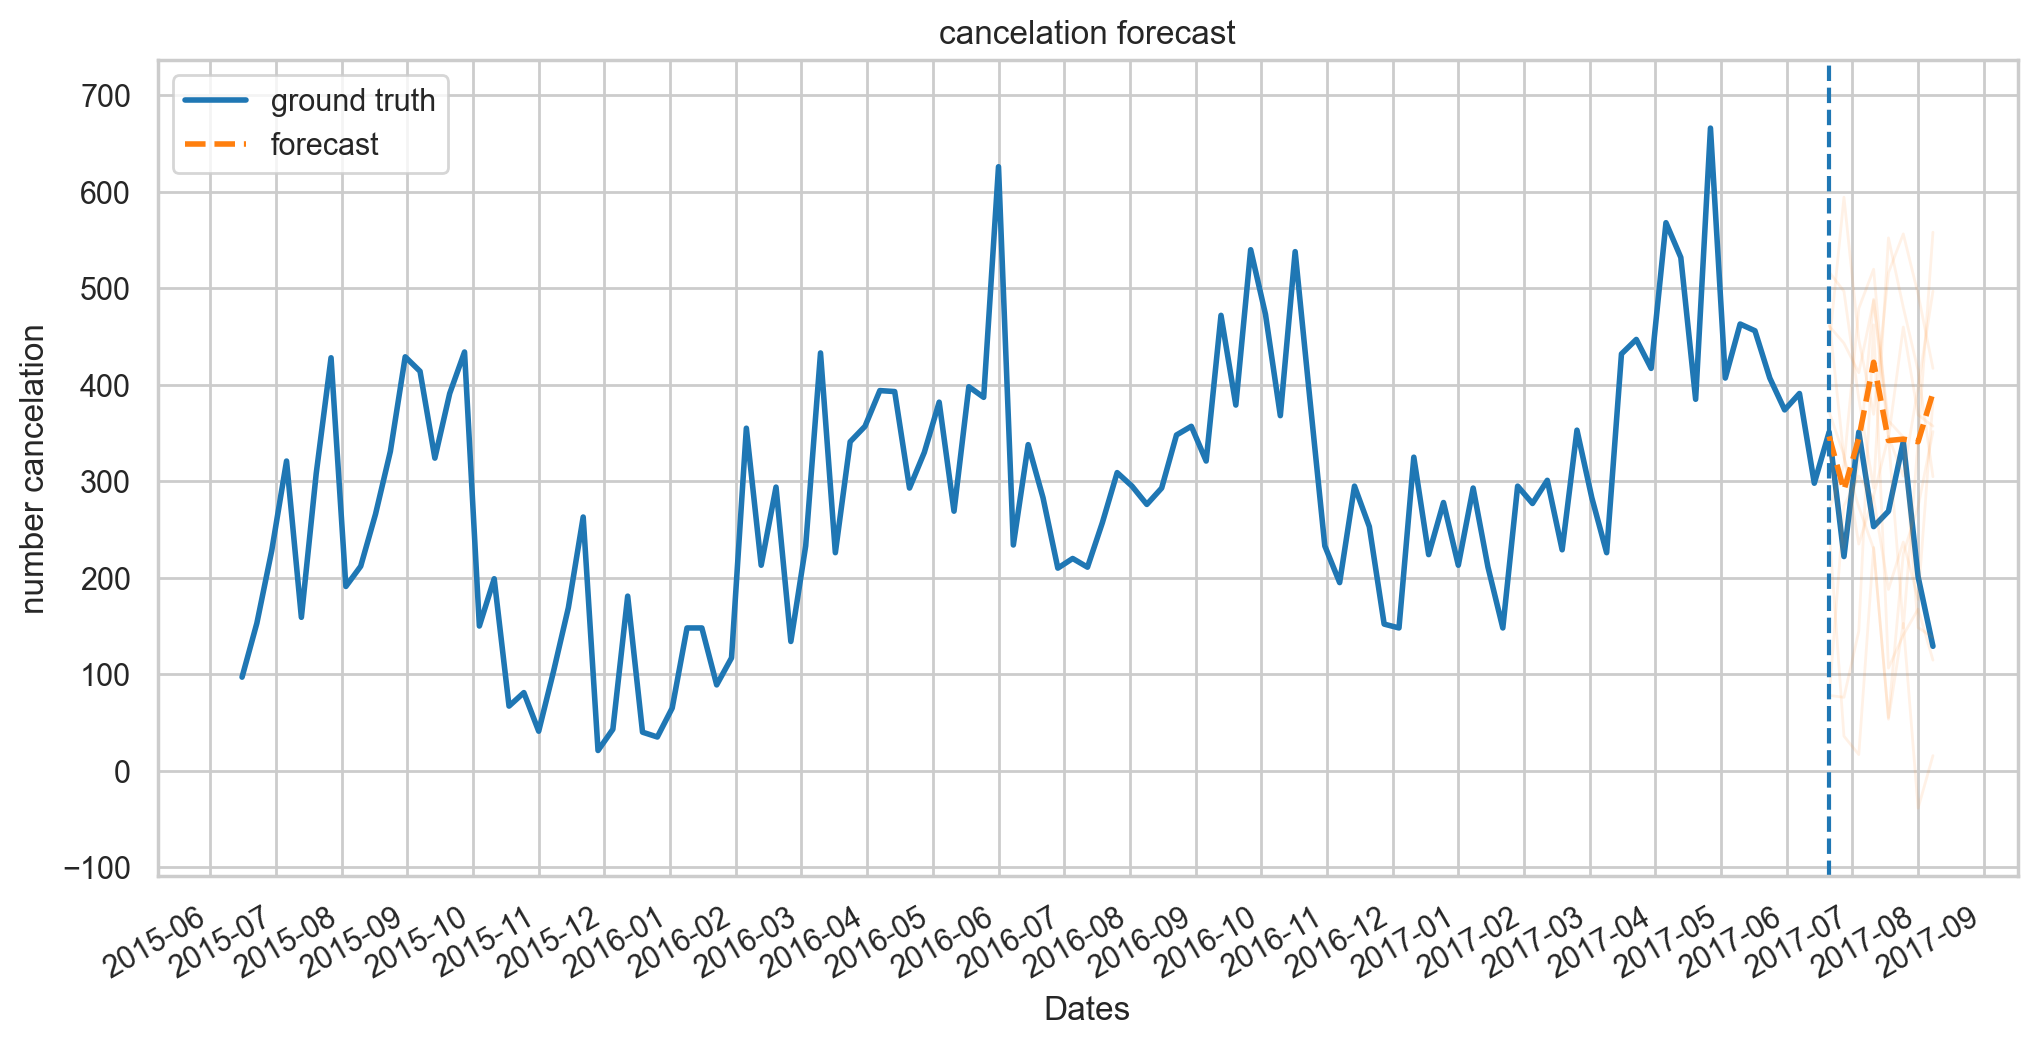

In [119]:
fig, ax = plot_forecast(
    cancelation_dates, serial_data,
    cancelation_forecast_mean, cancelation_forecast_scale, cancelation_forecast_samples,
    x_locator=cancelation_loc,
    x_formatter=cancelation_fmt,
    title="cancelation forecast")
ax.axvline(cancelation_dates[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("number cancelation")
ax.set_xlabel("Dates")
fig.autofmt_xdate()

In [120]:
### Mapping model components
component_dists = sts.decompose_by_component(
    cancelation_model,
    observed_time_series=training_data,
    parameter_samples=q_samples_cancelation_)

forecast_component_dists = sts.decompose_forecast_by_component(
    cancelation_model,
    forecast_dist=cancelation_forecast_dist,
    parameter_samples=q_samples_cancelation_)

In [121]:
cancelation_component_means_, cancelation_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

(
    cancelation_forecast_component_means_,
    cancelation_forecast_component_stddevs_
) = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
    )

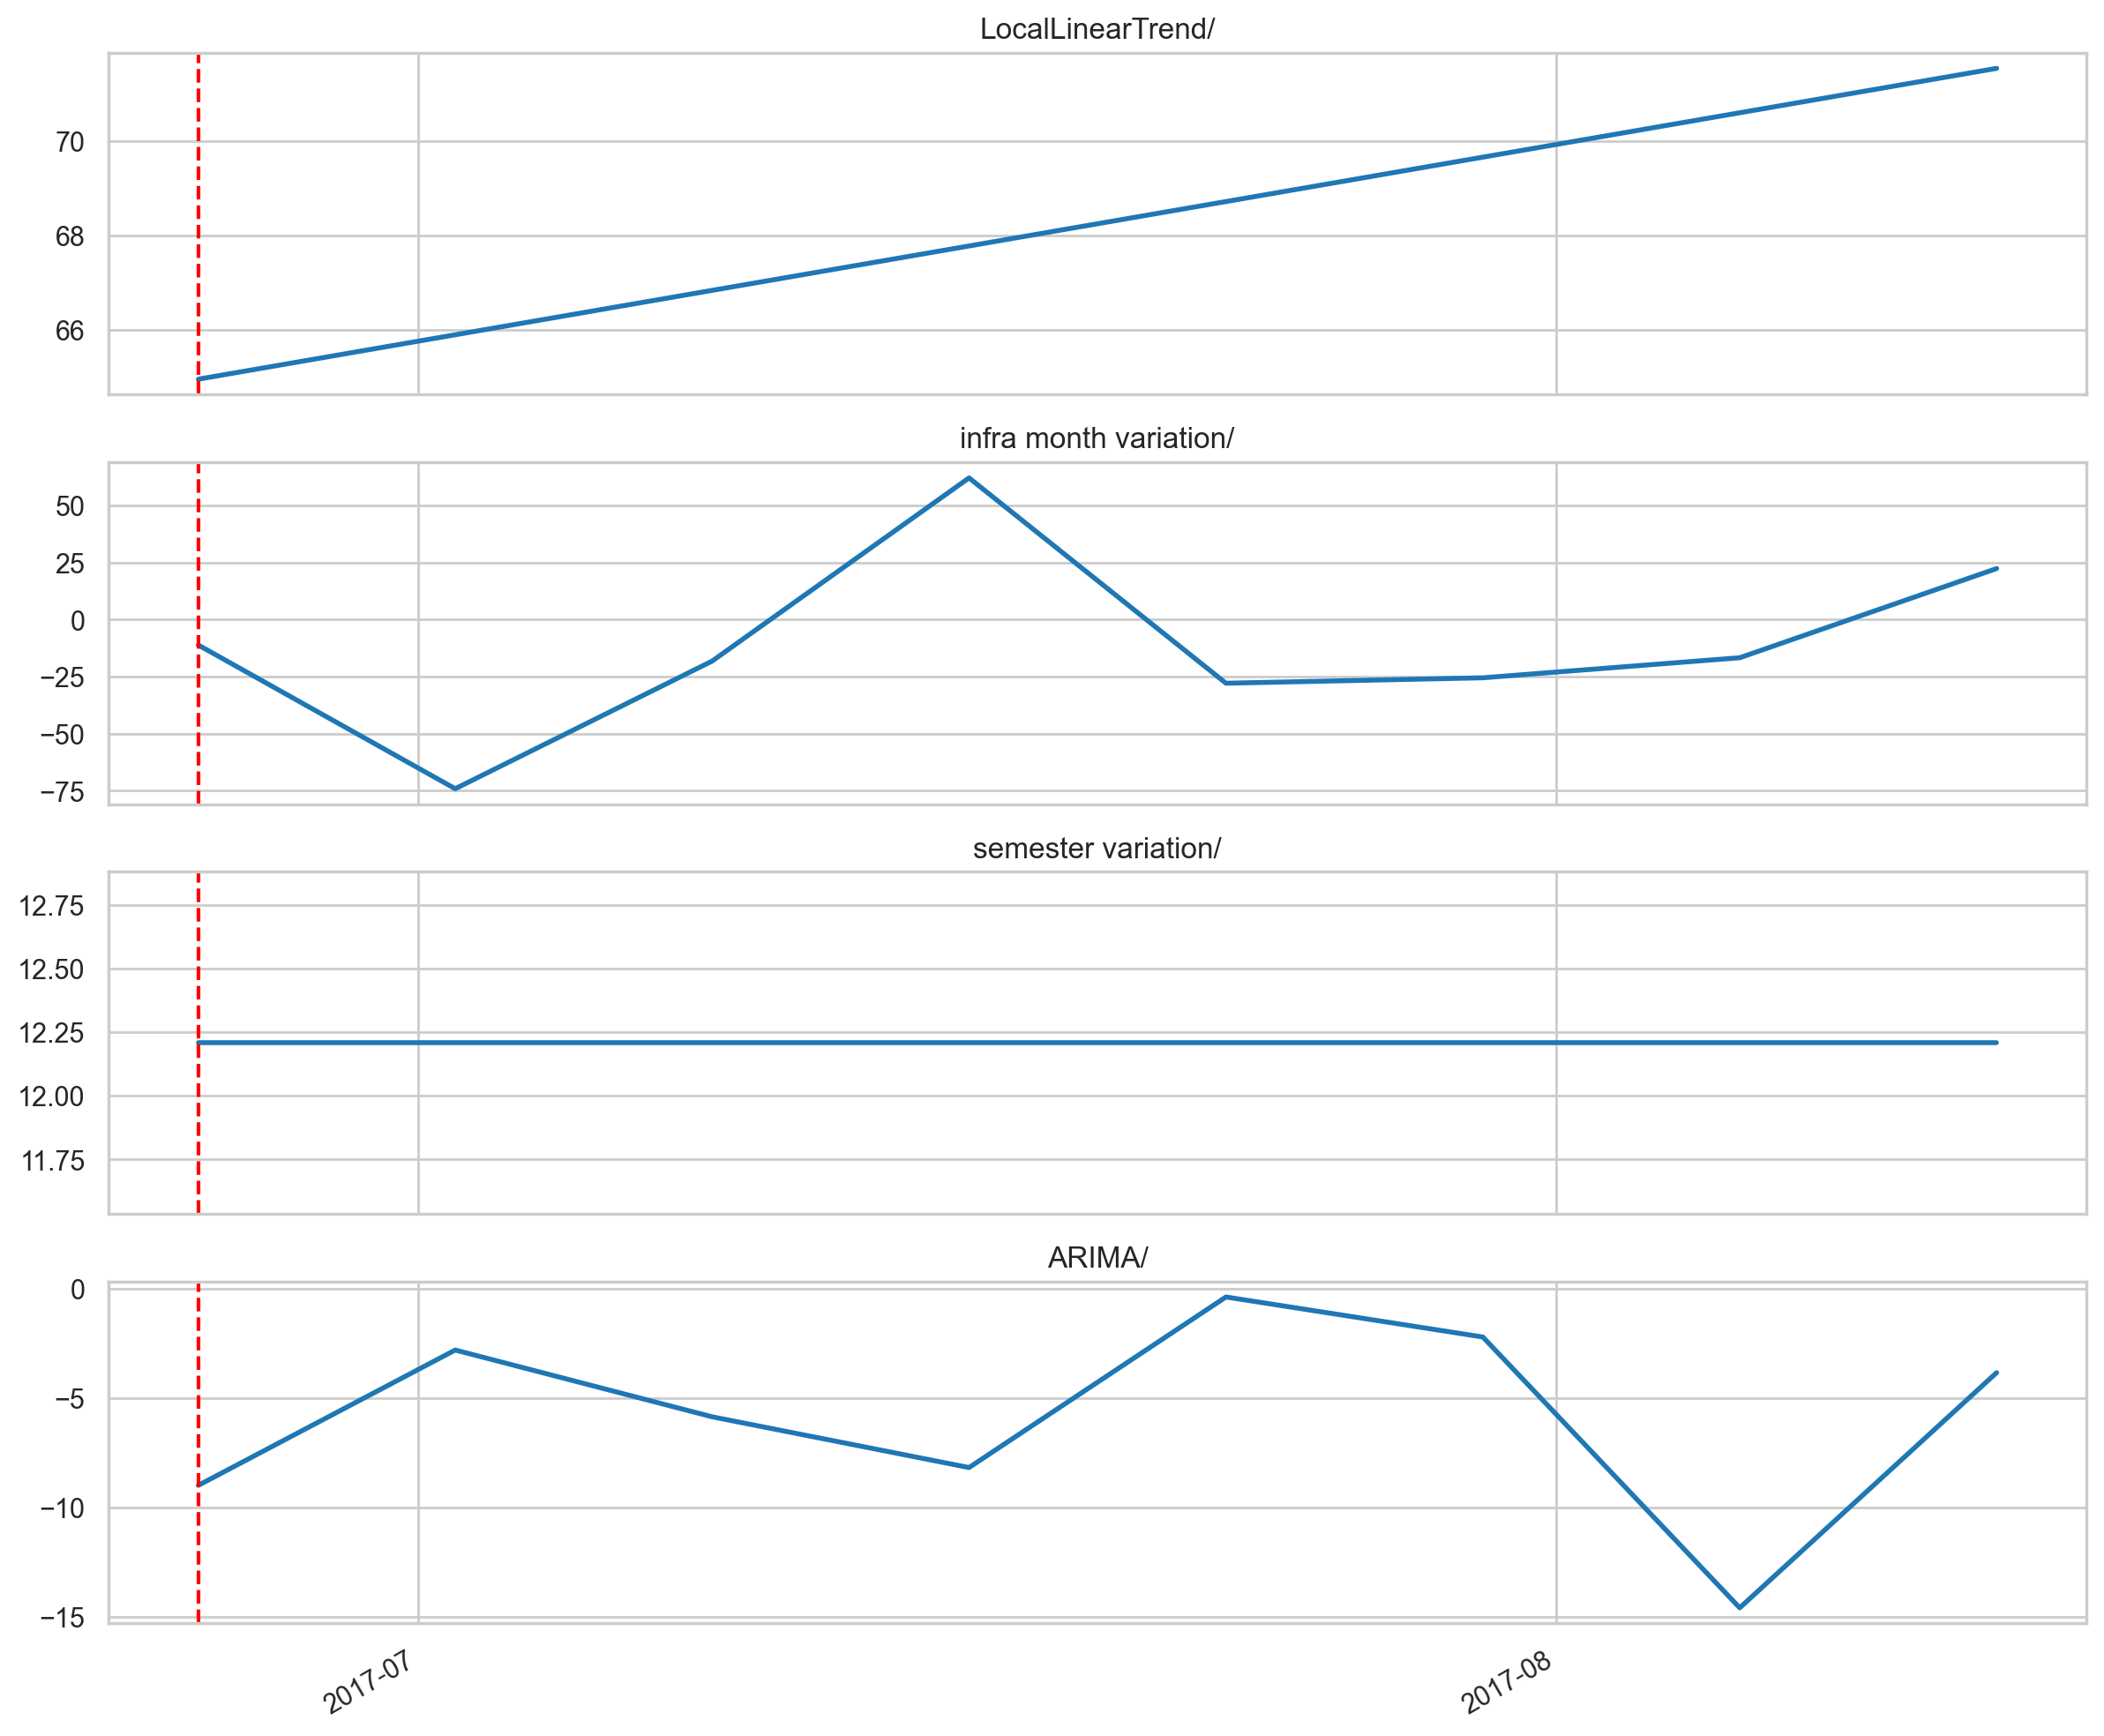

In [122]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in cancelation_component_means_.keys():
  component_with_forecast_means_[k] = np.concatenate([
      cancelation_component_means_[k],
      cancelation_forecast_component_means_[k]], axis=-1)
  component_with_forecast_stddevs_[k] = np.concatenate([
      cancelation_component_stddevs_[k],
      cancelation_forecast_component_stddevs_[k]], axis=-1)


fig, axes = plot_components(
  cancelation_dates,
  component_with_forecast_means_,
  component_with_forecast_stddevs_,
  x_locator=cancelation_loc, x_formatter=cancelation_fmt)
for ax in axes.values():
  ax.axvline(cancelation_dates[-num_forecast_steps], linestyle="--", color='red')

In [123]:
cancelation_one_step_dist = sts.one_step_predictive(
    cancelation_model,
    observed_time_series=serial_data,
    parameter_samples=q_samples_cancelation_)

cancelation_one_step_mean, cancelation_one_step_scale = (
    cancelation_one_step_dist.mean().numpy(), cancelation_one_step_dist.stddev().numpy())

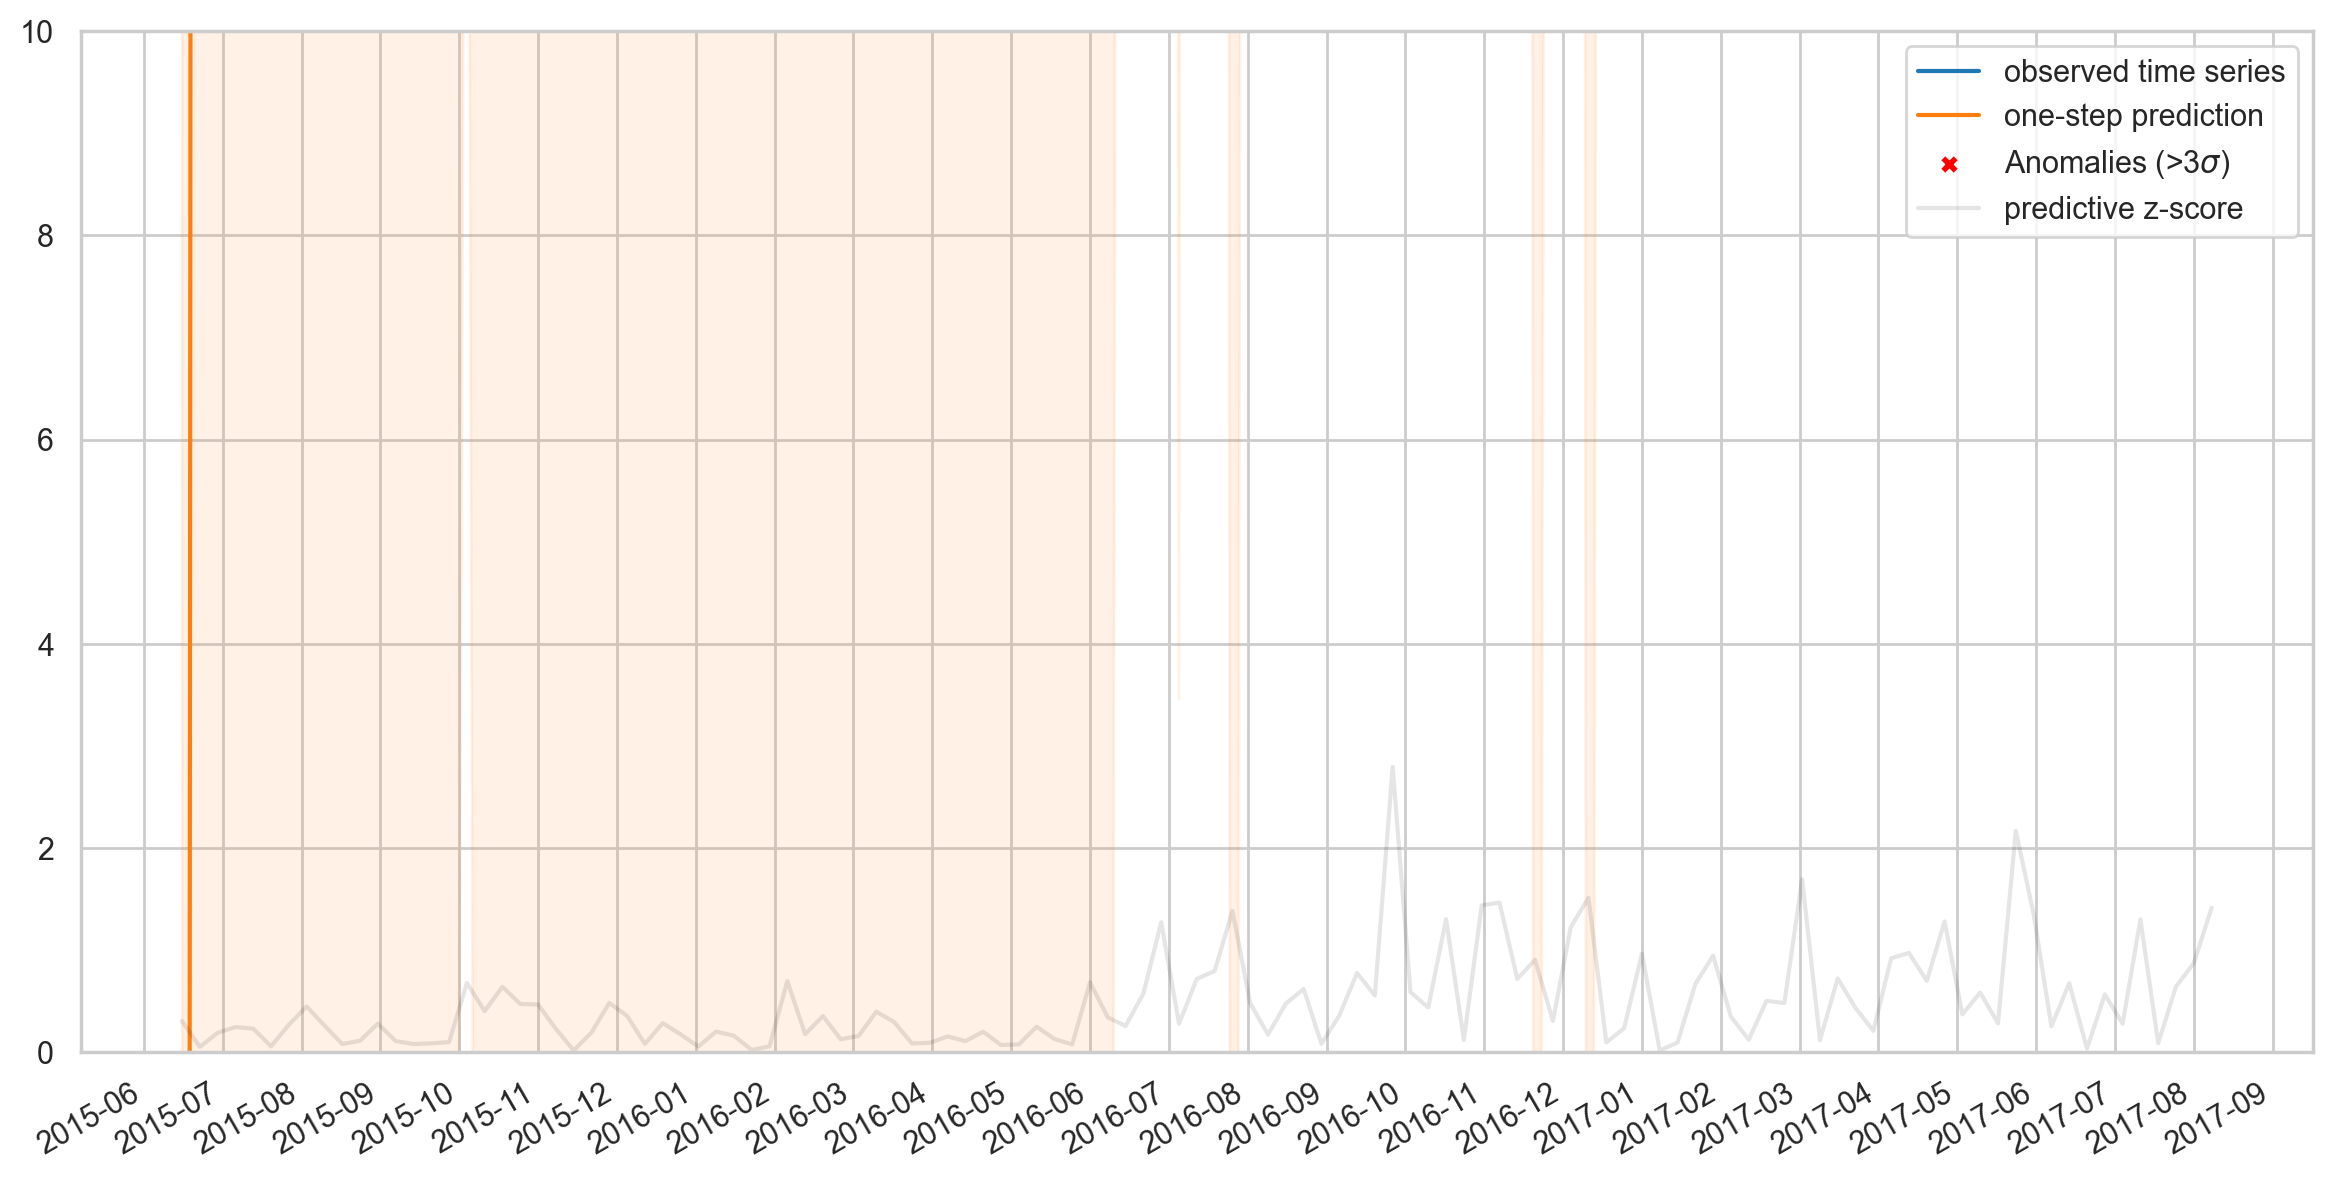

In [124]:
fig, ax = plot_one_step_predictive(
    cancelation_dates, serial_data,
    cancelation_one_step_mean, cancelation_one_step_scale,
    x_locator=cancelation_loc, x_formatter=cancelation_fmt)
ax.set_ylim(0, 10)

# Use the one-step-ahead forecasts to detect anomalous timesteps.
zscores = np.abs((serial_data - cancelation_one_step_mean) /
                 cancelation_one_step_scale)
anomalies = zscores > 3.0
ax.scatter(cancelation_dates[anomalies],
           serial_data[anomalies],
           c="red", marker="x", s=20, linewidth=2, label=r"Anomalies (>3$\sigma$)")
ax.plot(cancelation_dates, zscores, color="black", alpha=0.1, label='predictive z-score')
ax.legend()
plt.show()

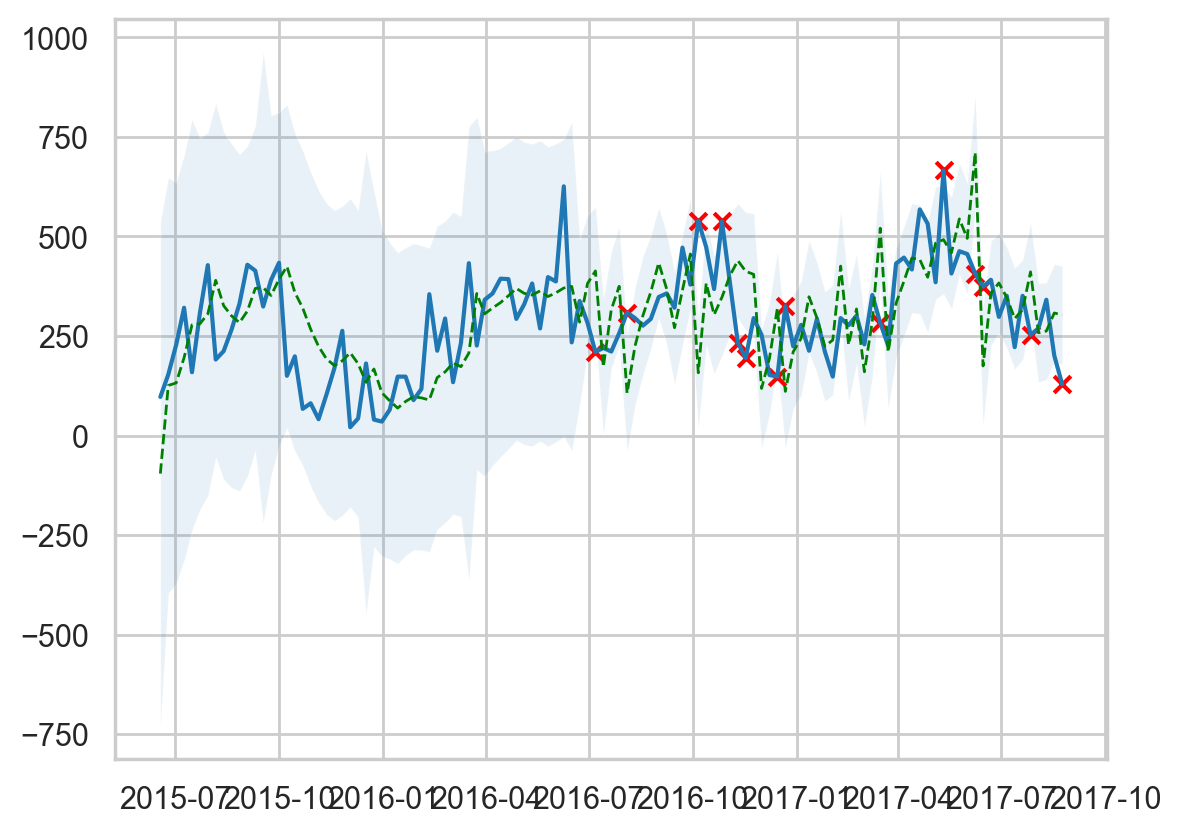

In [131]:
plt.plot(cancelation_dates, serial_data, label='Observed Time Series')

lower_bound = cancelation_one_step_mean - cancelation_one_step_scale
upper_bound = cancelation_one_step_mean + cancelation_one_step_scale

plt.fill_between(cancelation_dates, lower_bound, upper_bound, alpha=0.1, label='One Step Prediction Interval')

plt.plot(cancelation_dates, cancelation_one_step_mean, color='green', linestyle='--', linewidth=1, label='One Step Prediction')

outliers = (serial_data < lower_bound) | (serial_data > upper_bound)
outlier_indices = np.where(outliers)[0]
_ = plt.scatter(cancelation_dates[outlier_indices], serial_data[outliers], marker='x', color='red', label='Outliers')

In [130]:
len(lower_bound)

115

---